In [23]:
# Just to ignore warnings, in general you should NOT use this
import warnings
warnings.filterwarnings("ignore")

#import pyfits #module to read fits files
from astropy.io import fits
import matplotlib.pyplot as plt #module for plotting
import numpy as np #this module is for working with arrays like in matlab
import scipy as sp
from scipy import ndimage
from scipy.optimize import curve_fit

import pandas as pd

In [24]:
cube = fits.open(r"C:\Users\nicol\Documents\Astro_Exp\Informe 2 Experimental\southgal_fixbadc.fits") #open data cube object
data = cube[0].data #extract data matrix
header = cube[0].header #extract the header from the fits file

In [25]:
header

SIMPLE  =                    T  / Standard FITS format                          
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    3  / Number of axes                                
NAXIS1  =                  306  / Number pixels on axis 1                       
NAXIS2  =                  385  / Number pixels on axis 2                       
NAXIS3  =                   33  / Number pixels on axis 3                       
CTYPE1  = 'VELO-LSR'            / axis 1 coord type                             
CRVAL1  =        -2.307985E+02 / coord value at CRPIX1                          
CDELT1  =         1.300400E+00 / pixel spacing for axis 1                       
CRPIX1  =             1.000000  / ref pixel for axis 1                          
CTYPE2  = 'GLON-FLT'            / axis 2 coord type                             
CRVAL2  =         3.000000E+02 / coord value at CRPIX2                          
CDELT2  =         1.250000E-

In [26]:
data.shape

(33, 385, 306)

Aquí es bueno notar que la forma del array data no es necesariamente en el mismo orden de los ejes registrados en el header:  
en este caso, están reflejados, con el header teniendo velocidad, longitud y latitud (se puede ver en los CTYPEi),  
y data teniendo latitud, longitud y velocidad (al comnparar con las dimensiones se puede ver)

In [27]:
def values(h, j):
    N = h['NAXIS' + str(j)]
    val = np.zeros(N)
    for i in range(0, N):
        val[i] = (i + 1 - float(h['CRPIX' + str(j)])) * float(h['CDELT' + str(j)]) + float(h['CRVAL' + str(j)])
    return val

# Esta función, vista en auxiliar, permite extraer los valores del eje j de los datos, tomando en cuenta 
# las posibles diferencias en pixel de referencia, espaciado de pixeles y valores iniciales 

vel = values(header, 1)
lon = values(header, 2)
lat = values(header, 3)

# Por ejemplo, veamos los valores de velocidad:
lon

array([300.   , 300.125, 300.25 , 300.375, 300.5  , 300.625, 300.75 ,
       300.875, 301.   , 301.125, 301.25 , 301.375, 301.5  , 301.625,
       301.75 , 301.875, 302.   , 302.125, 302.25 , 302.375, 302.5  ,
       302.625, 302.75 , 302.875, 303.   , 303.125, 303.25 , 303.375,
       303.5  , 303.625, 303.75 , 303.875, 304.   , 304.125, 304.25 ,
       304.375, 304.5  , 304.625, 304.75 , 304.875, 305.   , 305.125,
       305.25 , 305.375, 305.5  , 305.625, 305.75 , 305.875, 306.   ,
       306.125, 306.25 , 306.375, 306.5  , 306.625, 306.75 , 306.875,
       307.   , 307.125, 307.25 , 307.375, 307.5  , 307.625, 307.75 ,
       307.875, 308.   , 308.125, 308.25 , 308.375, 308.5  , 308.625,
       308.75 , 308.875, 309.   , 309.125, 309.25 , 309.375, 309.5  ,
       309.625, 309.75 , 309.875, 310.   , 310.125, 310.25 , 310.375,
       310.5  , 310.625, 310.75 , 310.875, 311.   , 311.125, 311.25 ,
       311.375, 311.5  , 311.625, 311.75 , 311.875, 312.   , 312.125,
       312.25 , 312.

## Visualización del procedimiento 
 Paso por paso, estaré viendo las funciones del auxiliar para entenderlas,  
 y así poder avanzar luego con la implementación

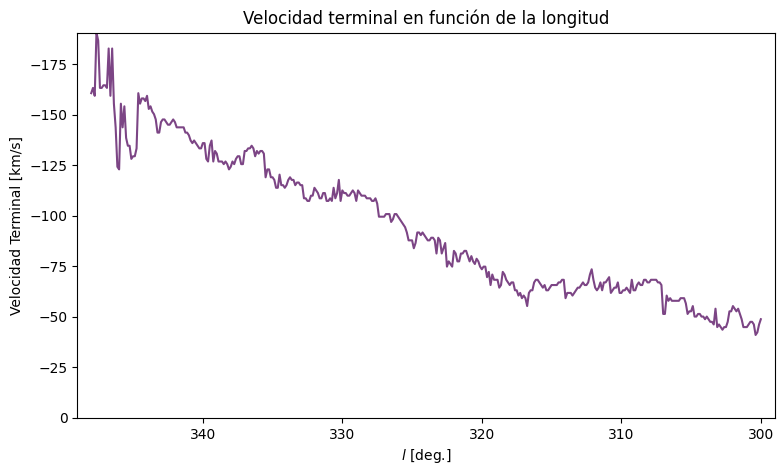

In [28]:
# Separación de las velocidades mínimas con máscaras

mask = data >= 0.8

# Broadcast a las velocidades para poder comparar con los datos en forma de cubo
vel_array = np.broadcast_to(vel, data.shape)

# Cambiamos las velocidades mayores 0.8 a np.inf
masked_vel = np.where(mask, vel_array, np.inf)

# Mínimos de cada (lat, lon)
min_vel = np.min(masked_vel, axis = 2)

# Encontramos los índices de latitud donde data coincide con los mínimos
lat_ind = np.argmin(min_vel, axis = 0)

# Velocidades mínimas por longitud
vt_lon = min_vel[lat_ind, np.arange(min_vel.shape[1])]

# Valores de latitud de los mínimos
lat_b = lat[lat_ind]

mins_table = np.column_stack((lon, lat_b, vt_lon))

######################################################

# Plot de lavelocidad terminal calculada en las longitudes
plt.figure(figsize = (9, 5))
plt.plot(lon, vt_lon, color = '#7C4585')
plt.xlim(349, 299.)
plt.ylim(0, np.min(vt_lon))
plt.xlabel(r'$l$ [deg.]')
plt.ylabel(r'Velocidad Terminal [km/s]')
plt.title('Velocidad terminal en función de la longitud')
plt.show()

In [29]:
from astropy.stats import sigma_clip

columns = ['longitude l', 'latitude b', 'v_tan']
table_data = []  # List to store rows before appending to the DataFrame

for i_b in range(len(lat)):
    for i_l in range(len(lon)):
        T = data[i_b][i_l][:] # Tomamos una "fila" de velocidades correspondientes a un (b, l)
        r = sigma_clip(T, sigma_lower=3, sigma_upper=3) # MaskedArray con quellos que pasan el criterio
        rms = np.sqrt(np.mean(r**2))
        rmask = r.mask # Condicional para aplicar a vel
        if len(vel[rmask]) == 0:
            v_tan = np.nan      # En caso de que ningun valor en ese vel pase el sigma, se deja un NaN
        else:
            v_tan = vel[rmask][0] # En otro caso, se toma el primer dato que pase el sigma
        
        # Se guarda como diccionario cada 3-tupla
        table_data.append({'longitude l': lon[i_l], 'latitude b': lat[i_b], 'v_tan': v_tan})

# DataFrame con los datos 
table = pd.DataFrame(table_data, columns=columns)

KeyboardInterrupt: 

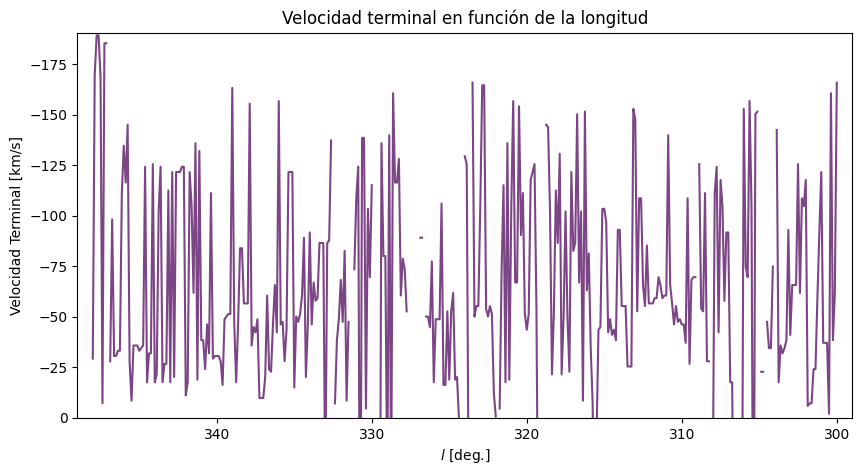

In [ ]:
# Prueba para visualizar que se consigue en el DataFrame 
# Como se puede ver, aún falta procesar los datos, 
# pero se puede ver algunos casos en que se registran NaN!

l_1 = [table['longitude l'][i] for i in range(385)]
v_1 = [table['v_tan'][i] for i in range(385)]

plt.figure(figsize = (10, 5))
plt.plot(l_1, v_1, color = '#7C4585')
plt.xlim(349, 299.)
plt.ylim(0, np.min(vt_lon))
plt.xlabel(r'$l$ [deg.]')
plt.ylabel(r'Velocidad Terminal [km/s]')
plt.title('Velocidad terminal en función de la longitud')
plt.show()

In [ ]:
# Falta escoger el mínimo para cada latitud 
# (conseguir solo un valor por latitud, 
# un proceso similar al anterior pero menos complejo) 

min_per_lat = np.zeros((len(lat), 2))
for i, b in enumerate(lat):
    table_b = table.loc[table['latitude b'] == b]
    min_vel = table_b['v_tan'].min()
    min_per_lat[i] = [b, min_vel]

# Ahora lo mismo pero con los mínimos por longitud

min_per_lon = np.zeros((len(lon), 2))
for i, l in enumerate(lat):
    table_b = table.loc[table['longitude l'] == l]
    min_vel = table_b['v_tan'].min()
    min_per_lat[i] = [l, min_vel]

## Implementación

### Constantes a usar en los cálculos de la curva de rotación

* $R_{0} = 8.5 [kpc]$
* $V(R_{0}) \sim 220 [\frac{km}{s}]$
* $\omega_{0} = \frac{V(R_{0})}{R_{0}} \sim 25.882 [\frac{km}{s\cdot kpc}]$

### Objetivo: 
 
Calcular la velocidad rotacional dada por 

\begin{align}
V(R = R_0 \sin(l)) = \frac{V^{\mathrm{max}}_{LSR} |\sin(l)|}{\sin(l)} + V(R_0) |\sin(l)|
\end{align}

In [ ]:
# Constantes mencionadas anteriormente

R0 = 8.5   # kpc
vsun = 220 # km/s
w0 = vsun/R0

# En la siguiente función se resume todo lo visto antes, pero en la definición esta es general
# para cualquier largo de datos que se tenga (se podría utilizar con otros archivos FITS)

def fmin(l, latitude, velocity, vs):
    #   Iteramos sobre la latitud 
        for b in range(len(latitude)):
    #       Vemos las velocidades de un (b, l) 
            T1 = data[b][l][:] 
            rms = np.sqrt(np.mean(T1**2))   # Calculo de RMS de ese array de vel
    #       Iteraciones sobre la velocidad
            for v in range(len(velocity)):
                if data[b][l][v] >= 5 * rms:  # Condicional para filtrar ruido
                    vs[b] = velocity[v]    # Se guarda la primera velocidad que no sea ruido
                    break

In [ ]:
# Cómo buscamos el maximorum sobre la longitud, debemos crear otra función que toma la longitud y entregue 
# los arrays de velocidades minimas y de sus correpondientes latitudes, además del array de R

def maximorums(longitude, latitude, velocity):
    n_l = len(longitude)
    n_b = len(latitude)
    vmin = np.zeros(n_l)  # Creamos los arrays de zeros que se modificarán después
    bvmin = np.zeros(n_l)
    R = np.zeros(n_l)
    Z = np.zeros(n_l)
    for i in range(n_l): # vamos sobre las longitudes
        vs = np.zeros(n_b)
        fmin(i, latitude, velocity, vs) # para conseguir el array de minimos para la latitud actual
        v1 = vs[0]          # Seteamos los primeros valoresde v y b 
        b1 = latitude[0]
        for j in range(n_b - 1): # iteramos spobre la latitud
            if vs[j + 1] < v1:  # se actualizan si se encuentra uno menor
                v1 = vs[j + 1]  
                b1 = latitude[j + 1]
        vmin[i] = v1    # una vez se itera sobre toda una latitud para una longitud, 
        bvmin[i] = b1   # se guarda el maximorum y el v minimo correspondiente
        R[i] = np.abs(R0 * np.sin(np.radians(longitude[i])))
        Z[i] = np.radians(b1) * R0 * np.cos(np.radians(longitude[i]))

    return vmin, bvmin, R, Z

# Ahora creamos una última función que devuelva el V(R) final que 
# buscamos para graficar la curvatura de la galaxia

def vr(longitude, vmin):
    n_l = len(longitude)
    l_rad = np.radians(longitude)
    vR = np.zeros(n_l) 
    for l in range(n_l): # Para cada longitud, una velocidad de rotación relacionada a esta
        vR[l] = vmin[l] * (np.abs(np.sin(l_rad[l]))) / np.sin(l_rad[l]) + np.abs(vsun * np.sin(l_rad[l]))

    return vR


len(lon)


385

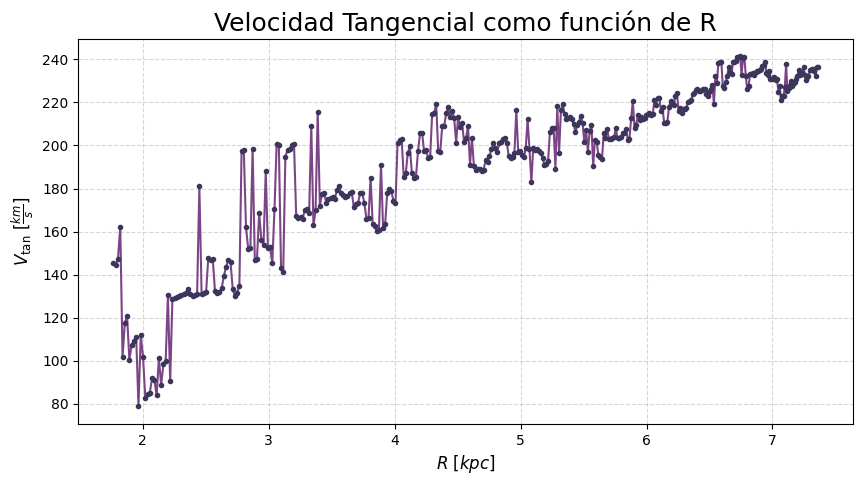

In [ ]:
# Aplicando las funciones a nuestros datos podremos graficar la curva de rotación  
# como V_rot vs R, inicialmente

vmin, bvmin, R, _ = maximorums(lon, lat, vel)

vR = vr(lon, vmin)

plt.figure(figsize=(10, 5))
plt.plot(R, vR, color = '#7C4585')
plt.plot(R, vR, linestyle = 'None', marker = '.', color = '#3D365C')
plt.grid
plt.title("Velocidad Tangencial como función de R", fontsize=18)
plt.xlabel("$R$ $[kpc]$", fontsize=12)
plt.ylabel(r"$V_{\mathrm{tan}}$ $[\frac{km}{s}]$", fontsize=12)
plt.grid(alpha=0.5, ls = '--')

* También podemos calcular la siguiente ecuación y graficar para $ \omega(R) $:

\begin{align}
V(R = R_0 \sin(l)) = \omega(R = R_0 \sin(l)) \cdot R_0 \cdot |\sin(l)|
\end{align}

 

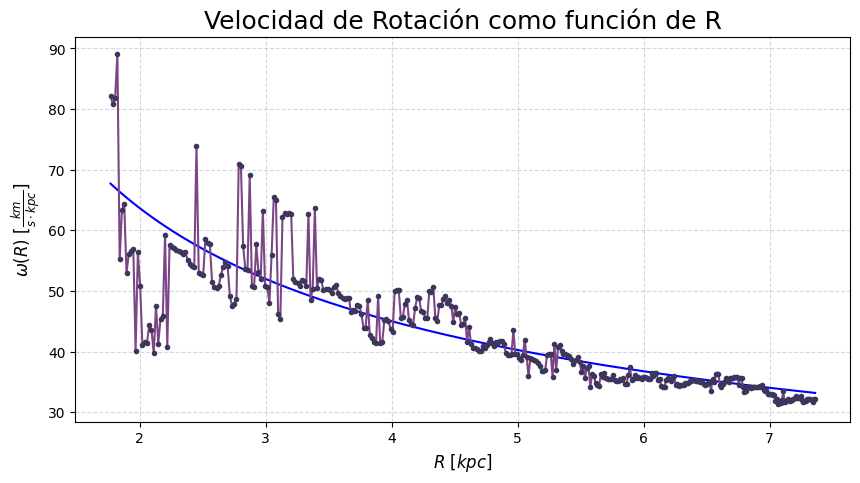

In [ ]:
def wr(vr, longitude):
    l_rad = np.radians(longitude)
    wR = vr / (R0 * np.abs(np.sin(l_rad))) # despeje simple de la ecuación de arriba
    return wR

wR = wr(vR, lon)

plt.figure(figsize=(10, 5))
plt.plot(R, 90*np.sqrt(1/R), color = 'blue')
plt.plot(R, wR, color = '#7C4585')
plt.plot(R, wR, linestyle = 'None', marker = '.', color = '#3D365C')
plt.grid
plt.title("Velocidad de Rotación como función de R", fontsize=18)
plt.xlabel("$R$ $[kpc]$", fontsize=12)
plt.ylabel(r"$\omega(R)$ $[\frac{km}{s \cdot kpc}]$", fontsize=12)
plt.grid(alpha=0.5, ls = '--')

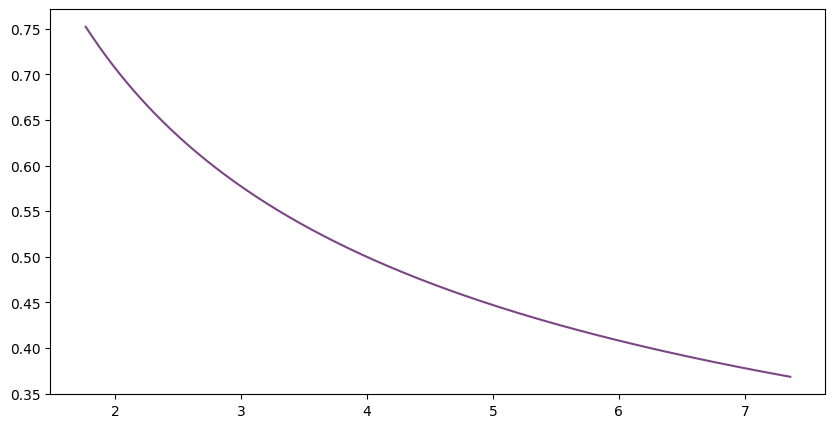

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(R, np.sqrt(1/R), color = '#7C4585')


* En la función maximorums definida anteriormente también se consigue un array para Z según la siguiente ecuación, tomando los valores de b de los maximorums encontrados en radianes: 

\begin{align}
Z = R_0 \cdot cos(l) \cdot b^{rad}
\end{align}

* Con esto se puede visualizar la corrugación del disco galáctico como función de R, como se ve en el siguiente plot:

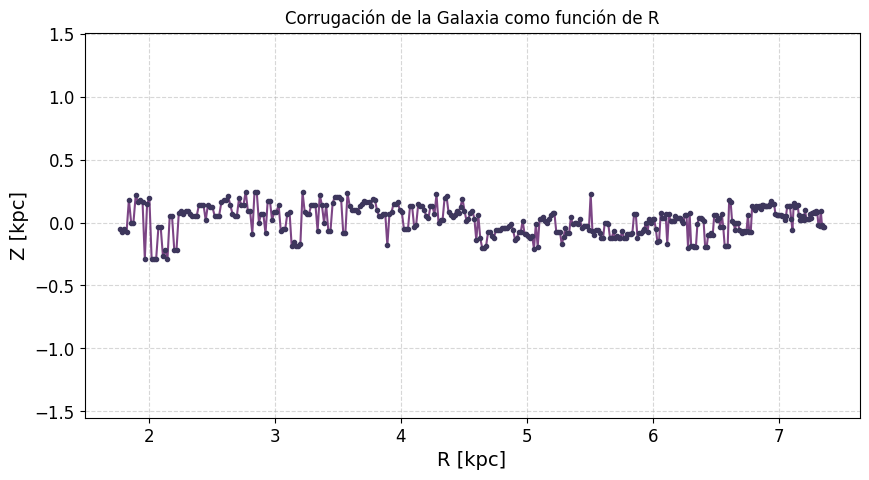

In [ ]:
_, _, _, Z = maximorums(lon, lat, vel)

plt.figure(figsize=(10, 5))
plt.plot(R, Z, color = '#7C4585')
plt.plot(R, Z, linestyle = 'None', marker = '.', color = '#3D365C')
plt.title("Corrugación de la Galaxia como función de R")
plt.xlabel("R [kpc]", fontsize='14')
plt.ylabel("Z [kpc]", fontsize='14')
plt.tick_params(labelsize='12')
plt.grid(alpha=0.5, ls = '--')
plt.axis('equal')
plt.show()

## Perfil de Masa de la Galaxia

* En esta parte se utilizarán funciones para representar los distintos perfiles y compararlos con los datos calculados de la curva de rotación


In [ ]:
# Constante gravitacional usando astropy

import astropy.units as u
import astropy.constants as c

G = c.G.to(u.kpc*u.km**2/u.Msun/u.s**2) # kpc*km**2/Msun/s**2

G.unit

Unit("km2 kpc / (solMass s2)")

### Masa Puntual
 
\begin{align}
M(R) =  M_0
\end{align}

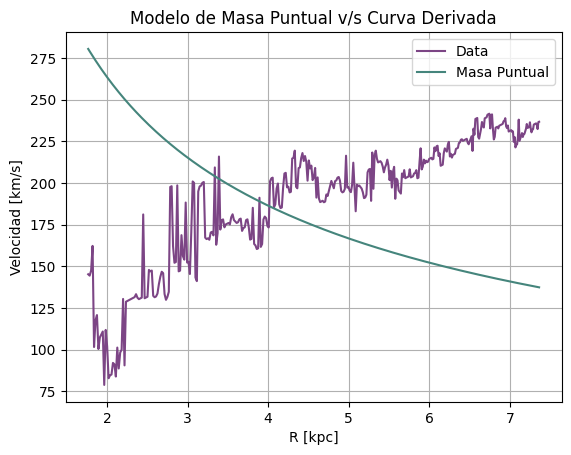

3.2293e+10


In [ ]:
def masapuntual(R, M0):
    v = np.sqrt(G.value * M0 / R) # km/s
    return v

mpuntual, covmpuntual = curve_fit(masapuntual, R, vR, bounds = (0, np.inf))

plt.plot(R, vR, '#7C4585', label='Data')
plt.plot(R, masapuntual(R, mpuntual[0]), '#45857c', label='Masa Puntual')
plt.xlabel('R [kpc]')
plt.ylabel('Velocidad [km/s]')
plt.title('Modelo de Masa Puntual v/s Curva Derivada')
plt.grid()
plt.legend()
plt.show()

print(f'{mpuntual[0]:.4e}')

### Disco

\begin{align}
M(R) = \pi \cdot R^{2} \cdot S
\end{align}

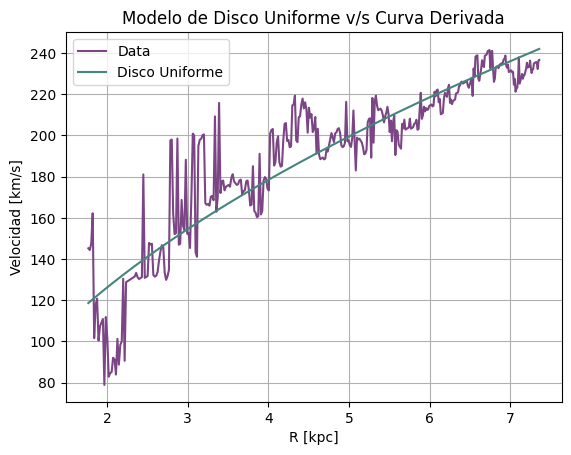

1.3367e+11


In [ ]:
def disco(R, S):
    M = np.pi * (R**2) * S
    v = np.sqrt(G.value * M / R) # km/s
    return v

disk, covdisk = curve_fit(disco, R, vR, bounds = (0, np.inf))

plt.plot(R, vR, '#7C4585', label='Data')
plt.plot(R, disco(R, disk[0]), '#45857c', label='Disco Uniforme')
plt.xlabel('R [kpc]')
plt.ylabel('Velocidad [km/s]')
plt.title('Modelo de Disco Uniforme v/s Curva Derivada')
plt.grid()
plt.legend()
plt.show()

M_circ_d = np.pi * (R0**2) * disk[0]

print(f'{M_circ_d:.4e}')

### Esfera 

\begin{align}
M(R) = \frac{4}{3} \cdot \pi \cdot R^{3} \cdot \rho 
\end{align}

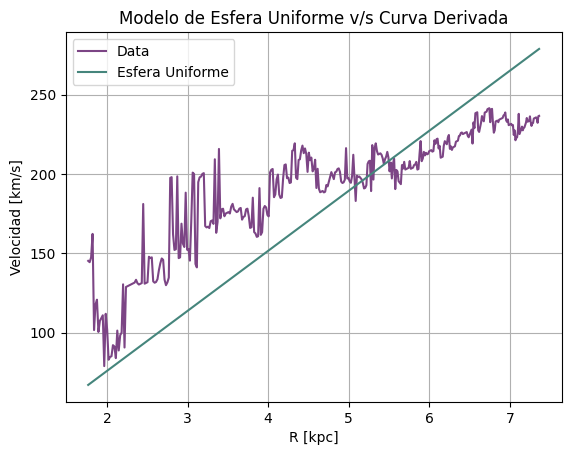

2.0493e+11


np.float64(79664495.09476027)

In [49]:
def esfera(R, rho):
    M = (4/3) * np.pi * (R**3) * rho
    v = np.sqrt(G.value * M / R) # km/s
    return v

sphere, covsphere = curve_fit(esfera, R, vR, bounds = (0, np.inf))

plt.plot(R, vR, '#7C4585', label='Data')
plt.plot(R, esfera(R, sphere[0]), '#45857c', label='Esfera Uniforme')
plt.xlabel('R [kpc]')
plt.ylabel('Velocidad [km/s]')
plt.title('Modelo de Esfera Uniforme v/s Curva Derivada')
plt.grid()
plt.legend()
plt.show()

M_circ_e = (4/3) * np.pi * (R0**3) * sphere[0] 

print(f'{M_circ_e:.4e}')

sphere[0]

### Disco + Masa Puntual en el centro

\begin{align}
M(R) = \pi \cdot R^{2} \cdot S + M_0
\end{align}

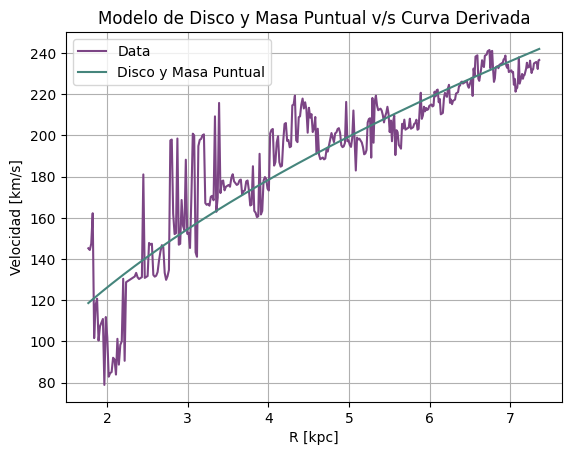

1.3367e+11
4.4046e+01


np.float64(588922859.2464254)

In [53]:
def disco_masa(R, S, M0):
    M = np.pi * (R**2) * S + M0
    v = np.sqrt(G.value * M / R) # km/s
    return v

disk_m, covdisk_m = curve_fit(disco_masa, R, vR, bounds = (0, np.inf))

plt.plot(R, vR, '#7C4585', label='Data')
plt.plot(R, disco_masa(R, disk_m[0], disk_m[1]), '#45857c', label='Disco y Masa Puntual')
plt.xlabel('R [kpc]')
plt.ylabel('Velocidad [km/s]')
plt.title('Modelo de Disco y Masa Puntual v/s Curva Derivada')
plt.grid()
plt.legend()
plt.show()

M_circ_dm = np.pi * (R0**2) * disk_m[0] + disk_m[1]

print(f'{M_circ_dm:.4e}')

print(f'{disk_m[1]:.4e}')

disk_m[0]


### Esfera Uniforme + Masa Puntual en el centro

\begin{align}
M(R) = \frac{4}{3} \cdot \pi \cdot R^{3} \cdot \rho + M_0
\end{align}

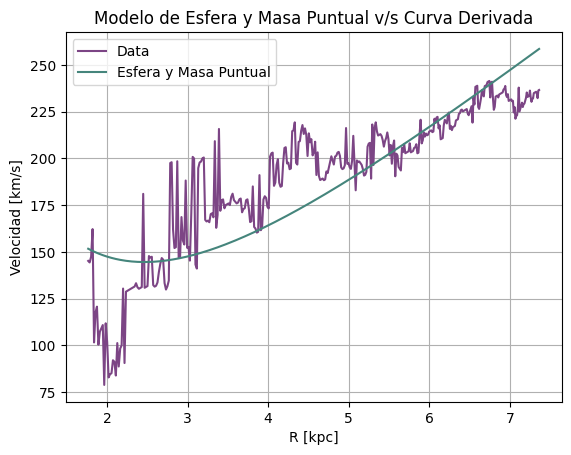

1.7195e+11
7.9826e+09


np.float64(63738159.54470715)

In [52]:
def esfera_masa(R, rho, M0):
    M = (4/3) * np.pi * (R**3) * rho + M0
    v = np.sqrt(G.value * M / R) # km/s
    return v

sphere_m, covsphere_m = curve_fit(esfera_masa, R, vR, bounds = (0, np.inf))

plt.plot(R, vR, '#7C4585', label='Data')
plt.plot(R, esfera_masa(R, sphere_m[0], sphere_m[1]), '#45857c', label='Esfera y Masa Puntual')
plt.xlabel('R [kpc]')
plt.ylabel('Velocidad [km/s]')
plt.title('Modelo de Esfera y Masa Puntual v/s Curva Derivada')
plt.grid()
plt.legend()
plt.show()

M_circ_em = (4/3) * np.pi * (R0**3) * sphere_m[0] + sphere_m[1]

print(f'{M_circ_em:.4e}')

print(f'{sphere_m[1]:.4e}')

sphere_m[0]
